In [1]:
import os
import json
import cv2
import random              as rd
import numpy               as np
import matplotlib.pyplot   as plt
import matplotlib.patches  as patches

from   glob   import glob
from   PIL    import Image

# custom functions
import Utils               as ut

# Dataset preparation

In [2]:
# important paths, modify them to match with your working folders

folder            = '/Volumes/HDD/WORK/Programming Projects/Fish interaction network/'   # working folder
json_folder_path  = folder + 'Sloth_3fish_annotation/'                                   # annotations path

Annotations are stored in .json files.

In [3]:
with open(json_folder_path + '2305_denity_DATA_1405_1.json', 'r') as file:
    data = json.load(file)

n = len(data)                 # visualize manually some files
for i in range(n):
   print(data[i]['filename'])

Data\_frames_1405_cowboyhills\recid3-14-01d_mp4\rectified_auto_resolution\00006010.jpg
Data\_frames_1405_cowboyhills\recid3-14-01d_mp4\rectified_auto_resolution\00012010.jpg
Data\_frames_1405_cowboyhills\recid3-14-01d_mp4\rectified_auto_resolution\00018010.jpg
Data\_frames_1405_cowboyhills\recid3-14-01d_mp4\rectified_auto_resolution\00024010.jpg
Data\_frames_1405_cowboyhills\recid3-14-01d_mp4\rectified_auto_resolution\00030110.jpg


In order to easily access the annotations we save them in the dictionary `image_annotations`.
 The latter takes as keys the images paths and for each image it stores the head/tail position of all the labeled fishes in that image. (There are in total 193.884 labeled fishes) 

In [4]:
json_files = glob(os.path.join(json_folder_path, '*.json'))
image_annotations = {}

unlabeled_img     =  ut.read_list_from_file("unlabeled_images.txt")
partially_labeled =  ut.read_list_from_file("partially_labeled_images.txt")
avoid_list        =  unlabeled_img + partially_labeled

for json_file in json_files:
    with open(json_file, 'r') as f:
        data = json.load(f)
        for item in data:
            filename = folder + item['filename'].replace('\\', '/')

            if filename not in avoid_list:

                annotations = item['annotations']
                fish_annotations = []
                for ann in annotations:
                    xn = ann['xn'].split(';')
                    yn = ann['yn'].split(';')

                    float_x = [round(float(num)) for num in xn] 
                    float_y = [round(float(num)) for num in yn] 

                    head_x, tail_x = float_x[0], float_x[1]
                    head_y, tail_y = float_y[0], float_y[1]

                    fish_annotations.append({
                        'head': (head_x, head_y),
                        'tail': (tail_x, tail_y)
                    })

                image_annotations[filename] = fish_annotations


To check that everything is working fine we can visualize the attotation by using the `draw_points` function.

In [5]:
idx = 1
image_path  = list(image_annotations.keys())[idx]
output_path = folder + 'result_image1.jpg'

heads_list = [(d['head']) for d in image_annotations[image_path]]
tails_list = [(d['tail']) for d in image_annotations[image_path]]

ut.draw_points(image_path, heads_list, (0, 0, 255), save_path = output_path)   # draw heads in red
ut.draw_points(output_path, tails_list, (0, 255, 0))                           # add tails in green


# PyTorch implementation

In [5]:
import torch
import torch.optim as optim
from   torchvision import transforms
from   torch.utils.data import Dataset, DataLoader
from   torchvision.models.detection import FasterRCNN
from   torchvision.transforms.functional import to_pil_image
from   torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from   torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

from   tqdm import tqdm  # Import tqdm for the progress bar

## DataSet object

We create a `FishDataset` class, this is very usefull to work with PyTorch. 

In [14]:
from torchvision.transforms import functional as F

class FishDataset(Dataset):

    def __init__(self, annotations, transform=None, subset_percentage=None):
        self.annotations = annotations
        self.resize = 3002 #1490, 3002 (img 49)
        self.transform = transform  

        # If subset_percentage is specified and valid, use it to limit the dataset size
        if subset_percentage is not None and 0 < subset_percentage < 100:
            subset_size = int(len(self.annotations) * (subset_percentage / 100))
            self.annotations = dict(list(self.annotations.items())[:subset_size])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = list(self.annotations.keys())[idx]
        img = Image.open(img_path).convert("RGB")
        original_width, original_height = img.size

        # Resize with padding
        img, padding = self.resize_with_padding(img, self.resize)
        
        target = self.annotations[img_path]

        boxes = []
        for ann in target:
            head = ann['head']
            tail = ann['tail']
            h = max(head[1], tail[1]) - min(head[1], tail[1])
            l = max(head[0], tail[0]) - min(head[0], tail[0])
            margin = max([h,l])/5
            
            # Calculate the scale factor for resizing
            scale = self.resize / max(original_width, original_height)
            # Apply padding and scale to bounding box coordinates
            xmin = ((min(head[0], tail[0]) - margin) * scale) + padding[0]
            xmax = ((max(head[0], tail[0]) + margin) * scale) + padding[0]
            ymin = ((min(head[1], tail[1]) - margin) * scale) + padding[2]
            ymax = ((max(head[1], tail[1]) + margin)  * scale) + padding[2]
            
            if margin*scale != 0:
                   extra_margin = margin*scale
            else:
                    extra_margin = 5

            if xmax-xmin < 5:

                xmax += extra_margin
                xmin -= extra_margin
            
            if ymax-ymin < 5:
                ymax += extra_margin
                ymin -= extra_margin

            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64) if boxes.size(0) else torch.zeros((0,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        if self.transform:
            img = self.transform(img)

        return img, target

    def resize_with_padding(self, img, target_size):
        """Resize the image with padding to maintain aspect ratio."""
        original_width, original_height = img.size
        ratio = target_size / max(original_width, original_height)
        new_width, new_height = int(original_width * ratio), int(original_height * ratio)
        img = F.resize(img, (new_height, new_width))

        # Calculate padding
        padding_left = (target_size - new_width) // 2
        padding_top = (target_size - new_height) // 2
        padding_right = target_size - new_width - padding_left
        padding_bottom = target_size - new_height - padding_top

        # Apply padding
        img = F.pad(img, (padding_left, padding_top, padding_right, padding_bottom))

        return img, (padding_left, padding_right, padding_top, padding_bottom)


We can now visualize the bounding box in our dataset as following.

In [15]:
transform = transforms.ToTensor()
dataset = FishDataset(image_annotations, transform=transform)

ut.draw_image_and_boxes(dataset, 46, path = folder+ 'boxes.png') 

<Figure size 1800x1200 with 0 Axes>

Note, the annotations quality is fundamental for acheaving a good training performance.

## Model selection & training

Load a pre-trained model with the API, note that we will set `num_classes = 2` since we want to classify fish vs background.

In [16]:
def get_model(num_classes):
    # Load a pre-trained model with the new weights parameter
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)
    
    # Replace the head of the model with a new one for your number of classes
    num_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(num_features, num_classes)
    
    return model

In [17]:
loss_list= []

def train_model(model, dataset, num_epochs=10):
    data_loader = DataLoader(dataset, batch_size = 4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    
    # Move model to the right device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    # Construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=0.0005, momentum=0.6, weight_decay=0.0005)
    
    # And a learning rate scheduler
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for batch_idx, (images, targets) in progress_bar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Optimization step
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            running_loss += losses.item()
            progress_bar.set_postfix({'loss': running_loss / (batch_idx + 1)})
        
        # Print average loss at the end of the epoch
        print(f"Epoch {epoch + 1} Average Loss: {running_loss / len(data_loader)}")
        loss_list.append(running_loss / len(data_loader))
        
        # Update the learning rate
        lr_scheduler.step()
    
    print("Training complete")


# Assuming you have an instance of your dataset
num_epochs = 5
transform = transforms.ToTensor()
fish_dataset = FishDataset(image_annotations, subset_percentage=100, transform=transform)
model = get_model(num_classes=2) # Including the background as a class
train_model(model, fish_dataset, num_epochs)


Epoch 1/5: 100%|██████████| 25/25 [08:10<00:00, 19.62s/it, loss=2.17]


Epoch 1 Average Loss: 2.1707269048690794


Epoch 2/5: 100%|██████████| 25/25 [08:08<00:00, 19.52s/it, loss=1.3] 


Epoch 2 Average Loss: 1.3028674221038818


Epoch 3/5: 100%|██████████| 25/25 [08:10<00:00, 19.61s/it, loss=1.25]


Epoch 3 Average Loss: 1.249915270805359


Epoch 4/5: 100%|██████████| 25/25 [08:06<00:00, 19.46s/it, loss=1.22]


Epoch 4 Average Loss: 1.2189658641815186


Epoch 5/5: 100%|██████████| 25/25 [08:03<00:00, 19.34s/it, loss=1.22]

Epoch 5 Average Loss: 1.217639741897583
Training complete


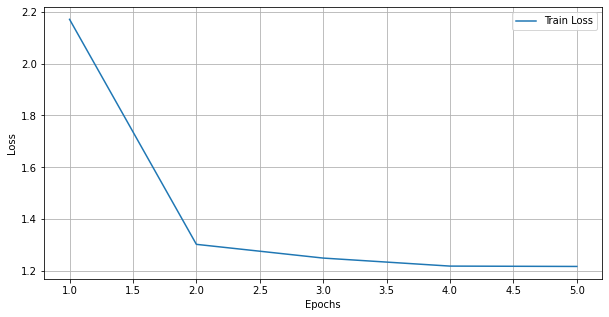

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_list, label='Train Loss')
#plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title(f'Fold {fold_idx + 1} - Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

Now let's save the model.

In [8]:
torch.save(model.state_dict(), folder + 'model1_weights.pth')

## Predictions on unlabeled images

Firstly we load our pre-saved model.

In [21]:
model = get_model(num_classes=2)
model.load_state_dict(torch.load('model1_weights.pth'))

<All keys matched successfully>

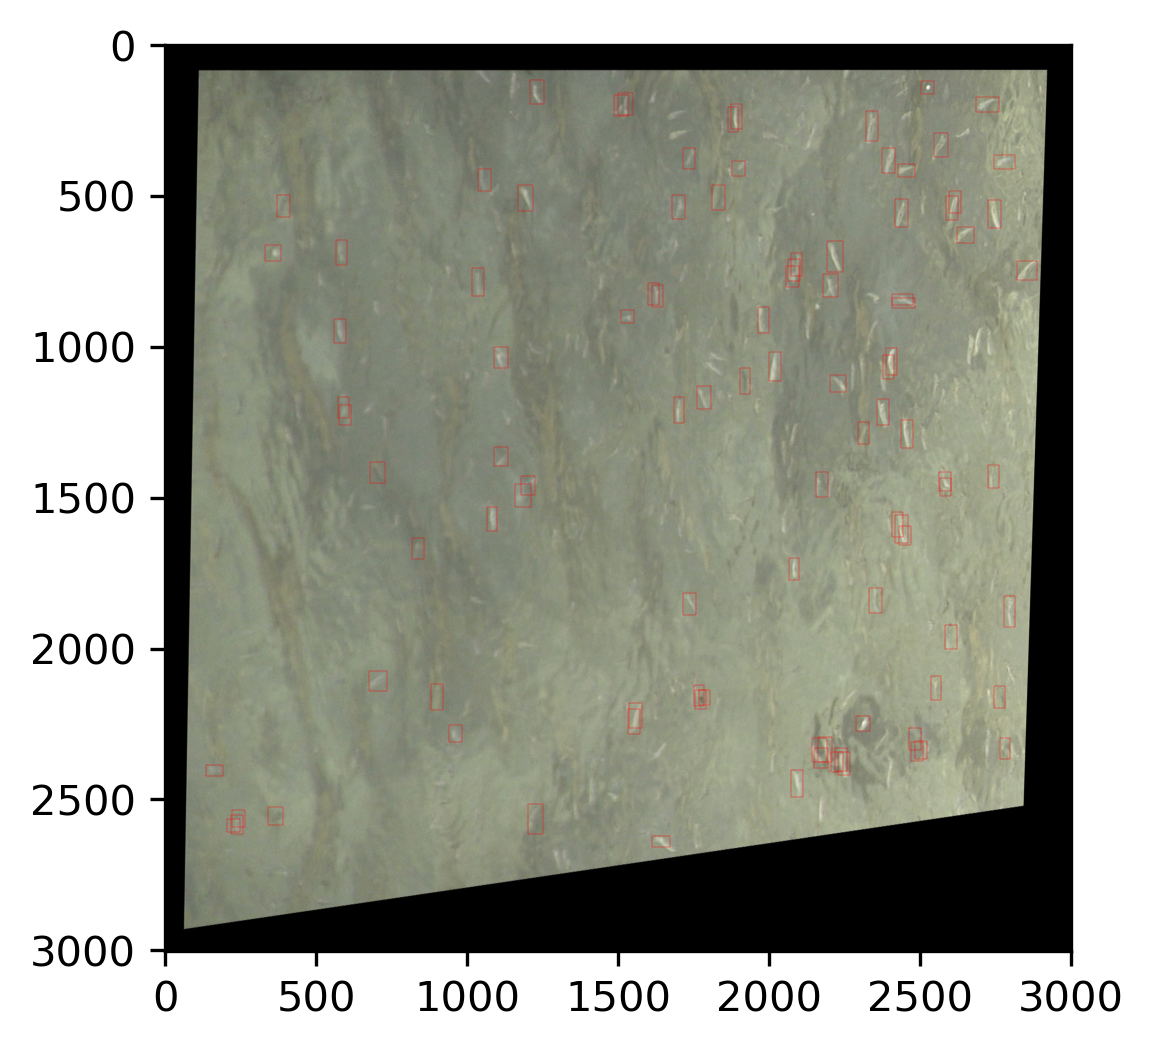

In [32]:
random_img = rd.sample(unlabeled_img, 1)[0]

transformed_img = ut.load_transform_image(random_img, resize=3002)

prediction = ut.predict(model, transformed_img)

ut.draw_predictions(transformed_img, prediction, threshold=0.3)

In [12]:
prediction

[{'boxes': tensor([[ 483.7880,  782.2672,  507.7520,  801.7386],
          [ 467.7508,  837.3664,  487.0626,  859.8543],
          [ 207.9389,  269.6968,  231.5598,  287.0217],
          [ 216.0433,  609.7527,  232.8774,  630.3737],
          [ 399.5700,  541.5167,  416.5556,  557.4597],
          [ 177.9156,  328.2769,  196.6648,  348.5062],
          [ 341.8221,  761.9046,  356.2534,  790.6772],
          [ 116.2818,  461.8472,  129.5073,  484.2803],
          [ 275.4282,  899.5217,  295.5833,  922.6724],
          [ 196.2923,  380.2268,  215.4873,  405.3412],
          [ 202.8067,  271.9176,  225.0915,  289.3782],
          [ 164.2512,  656.8224,  179.1199,  679.6606],
          [ 644.5964,  598.9011,  657.2087,  624.8809],
          [ 167.7959,  850.0034,  187.8409,  870.8938],
          [ 351.8113,  939.8500,  366.6347,  960.7146],
          [ 450.1323,  915.3718,  467.9066,  930.7059],
          [ 508.9394,  691.1989,  523.6325,  719.7275],
          [ 590.5544,  660.1723,  607.6

In [25]:
# Example: Evaluate on a single training sample
with torch.no_grad():
    sample_img, _ = fish_dataset[40]  # Assuming you have access to your training dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sample_pred = model([sample_img.to(device)])
    # Continue as before to visualize predictions


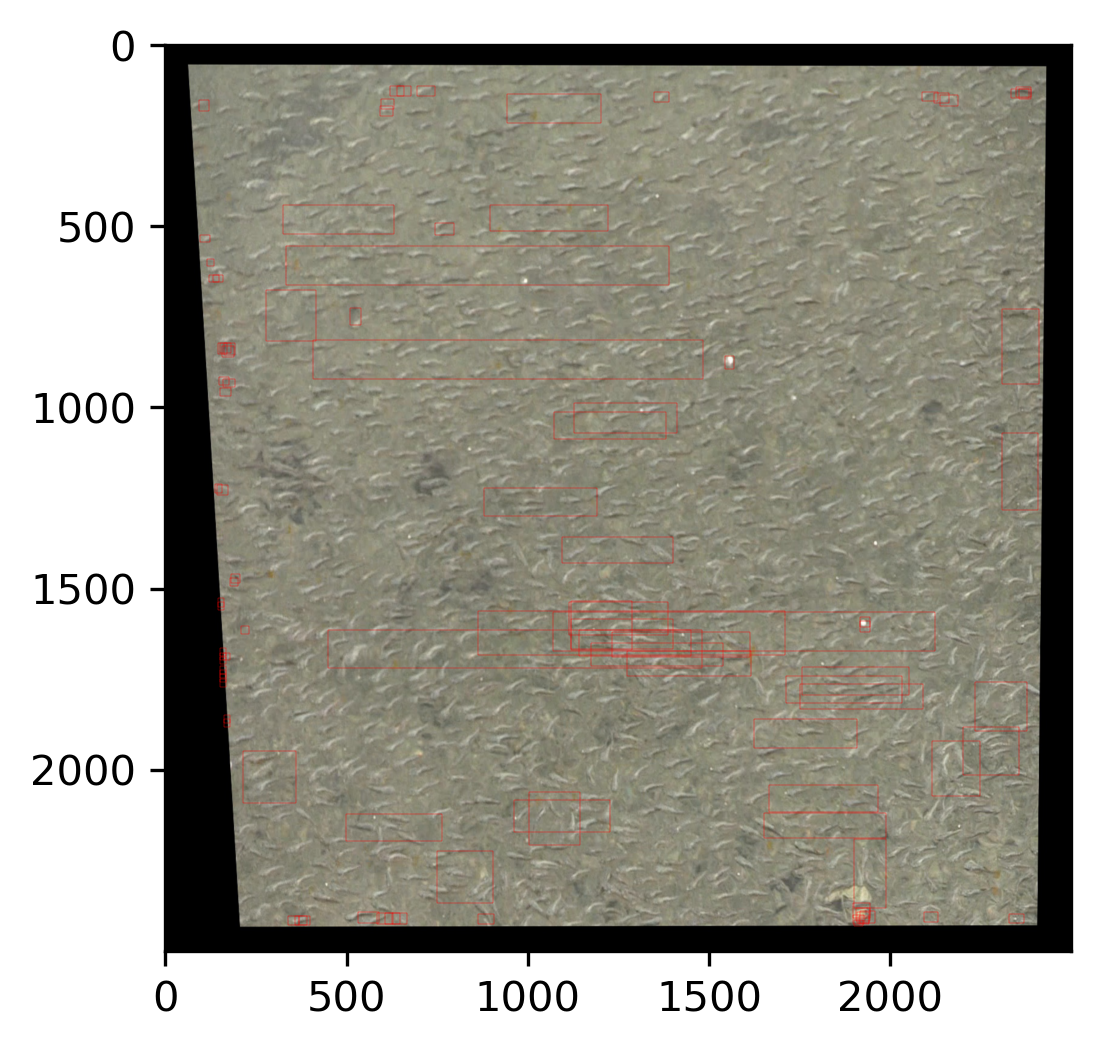

In [26]:
ut.draw_predictions(sample_img, sample_pred, threshold=0.1)


In [42]:
sample_pred

[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])}]

# TensorFlow implementation

In [1]:
import tensorflow as tf
import tflite_model_maker

from   tflite_model_maker.config import ExportFormat, QuantizationConfig
from   tflite_model_maker import model_spec
from   tflite_model_maker import object_detector
from   tflite_support import metadata



assert tf.__version__.startswith('2')
tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

2024-04-10 08:48:13.940147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/lucagiaccone/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'tflite_model_maker'

In [ ]:
train_data = object_detector.DataLoader.from_pascal_voc(
    'android_figurine/train',
    'android_figurine/train',
    ['android', 'pig_android']
)

val_data = object_detector.DataLoader.from_pascal_voc(
    'android_figurine/validate',
    'android_figurine/validate',
    ['android', 'pig_android']
)

In [ ]:
spec = model_spec.get('efficientdet_lite0')

In [ ]:
model = object_detector.create(train_data, model_spec=spec, batch_size=4, train_whole_model=True, epochs=20, validation_data=val_data)

In [ ]:
model.evaluate(val_data)

In [ ]:
model.export(export_dir='.', tflite_filename='android.tflite')